In [9]:
import pandas as pd
import numpy as np
import pandas_profiling 
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import unidecode as uni
import time
import pickle
pd.set_option('display.max_columns', None)
with open('resultados_regresiones_revenue.pickle', 'rb') as handle:
    XGBRegressorRevenue = pickle.load(handle)
    
def Outliers(p_data, Desviacion):
    data_modificada = p_data
    
    # GENERO CULUMNA DE MEDIAS AGRUPANDO
    media__ = data_modificada.groupby(['Budget','Animation','Biography','Comedy','Drama'])['RuntimeMinutes'].transform('mean')
    #GENERO COLUMNA DE STD AGRUPANDO
    str__ = data_modificada.groupby(['Budget','Animation','Biography','Comedy','Drama'])['RuntimeMinutes'].transform('std')
    #GENERO COLUMNA CON LA FORMULA DE CHEUVENET PARA EL CALCULO DE OUTLIERS
    criterio_cheuvenet__ = (abs(data_modificada.RuntimeMinutes-media__))/(str__)

    data_modificada.RuntimeMinutes.loc[criterio_cheuvenet__>Desviacion] = np.nan
    return data_modificada 

def eliminar_features(p_modeloMatriz):
    modeloMatriz = p_modeloMatriz
    modeloMatriz.astype(int)
    xs = modeloMatriz.drop(['RuntimeMinutes'],axis=1)
    y = modeloMatriz.RuntimeMinutes
    df = modeloMatriz[['RuntimeMinutes']]
    for i in xs.columns:
#DEJO 30 VARIABLES PARA QUE EXPLIQUEN EL MODELO
        if abs(y.corr(xs[i]))>0.07: 
            df = pd.concat([df, pd.DataFrame(xs[i])],axis=1)
    return df 

## ARMANDO DATASET DE PELICULAS

In [10]:
data = pd.read_csv('data_movies_final.csv',sep='|').iloc[:,1:]
data['Rate'][data.Rate>10] = data.Rate[data.Rate>10]*0.10
data['fecha_mes'] = data['fecha'][data.fecha.notnull()]
dummies_meses = pd.get_dummies(data.fecha_mes[data.fecha_mes.notnull()].str.split(pat='-').apply(lambda x: x[1])).rename(columns={'01':'ENERO','02':'FEBRERO','03':'MARZO','04':'ABRIL','05':'MAYO','06':'JUNIO','07':'JULIO','08':'AGOSTO','09':'SEPTIEMBRE','10':'OCTUBRE','11':'NOVIEMBRE','12':'DICIEMBRE'})
data = pd.concat([data,dummies_meses],axis=1)
data = data[data.fecha_mes.notnull()]
data = data.drop(['IDDataLens','cant_baja_votos','cant_media_votos','cant_alta_votos','fecha_mes'],axis=1)
dataApropiado = pd.read_csv('data_apropiado.csv',sep='|').iloc[:,1:]
dataApropiado = dataApropiado.drop_duplicates()
data = data.merge(dataApropiado,how='left',left_on='Title',right_on='Title')
data['fecha_anio'] = data.fecha.str.split(pat='-').apply(lambda x: x[0])
data = data.drop(['popularity','largo_letras_titulo'],axis=1).drop_duplicates()
nuevaRate = pd.DataFrame(data.groupby(['Title'])['Rate'].mean()).reset_index()
data = data.merge(nuevaRate, how='left',left_on='Title',right_on='Title')
data['fecha_anio'] = data.fecha_anio.astype(int)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
data_predict = data.drop(['Title','Rate_x','revenue','fecha','Rate_y'],axis=1)
revenue_predicho = pd.Series(XGBRegressorRevenue.predict(data_predict))
data.revenue.update(revenue_predicho)
data = data.drop(['fecha','Rate_y'],axis=1)
data = data.dropna()
data = data.drop_duplicates()

In [12]:
data = pd.concat([data,pd.get_dummies(pd.qcut(data.Rate_x,3,labels=['bajo_rate','medio_rate','alto_rate']))],axis=1).drop(['Rate_x'],axis=1)
data = pd.concat([data,pd.get_dummies(pd.qcut(data.revenue,3,labels=['bajas_ganancias','medios_ganancias','altas_ganancias']))],axis=1).drop(['revenue'],axis=1)

In [13]:
df = data.dropna()
df = data.drop_duplicates()

In [14]:
df = df[Outliers(df,1.15).RuntimeMinutes.notnull()]

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## SEPARO X y

In [15]:
X = df.drop(['Title','RuntimeMinutes'],axis=1)
y = df.RuntimeMinutes

In [16]:
X

,Budget,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,ENERO,FEBRERO,MARZO,ABRIL,MAYO,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE,apropiado,fecha_anio,bajo_rate,medio_rate,alto_rate,bajas_ganancias,medios_ganancias,altas_ganancias
2,30000000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1995,0,1,0,0,1,0
3,30000000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2011,0,1,0,0,1,0
6,30000000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1995,1,0,0,0,1,0
7,30000000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2011,1,0,0,0,1,0
11,1538000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1958,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184221,69000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2013,1,0,0,0,0,1
184224,45000000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2000,0,0,1,0,0,1
184225,45000000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2000,0,1,0,0,0,1
184231,149000000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,2006,0,1,0,0,1,0


## IMPORTO LIBRERIAS DE SKLEARN PARA APRENDIZAJE SUPERVISADO

In [8]:
# Regressions
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# Boost Tuneados
from xgboost.sklearn import XGBRegressor,XGBClassifier
from catboost import CatBoostRegressor,CatBoostClassifier

## DEFINICION DE PROCESO GRIDSEARCH SKLEARN

In [9]:
def test_regresiones_sklearn(p_X, p_y):
    modelos_regresion = [LinearRegression(),
                         Ridge(),
                         Lasso(),
                         AdaBoostRegressor(),
                         GradientBoostingRegressor(),
                         RandomForestRegressor(),
                         XGBRegressor(),
                         CatBoostRegressor()]
    
    X = p_X
    y = p_y
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    
    parametros_LinealRegression = {}
    parametros_Ridge = {'alpha':[0.1,0.5,1]}
    parametros_Lasso = {'alpha':[1]}
    parametros_AdaBoostRegressor = {'random_state':[42],'n_estimators':[2,5]}
    parametros_GradientBoostRegressor = {'random_state':[42],'max_depth':[17],'n_estimators':[25]}
    parametros_RandomForestRegressor = {'random_state':[42],'max_depth':[30],'n_estimators':[26]}
    parametros_XGBoostRegressor = {'max_depth':[14],'iterations':[2],'alpha':[0],'learning_rate':[0.3]}
    parametros_CatboostRegressor = {'max_depth':[5,7],'iterations':[5,7],'learning_rate':[2]}
    
    dicccionario_modelos = {0:'Regresiones Lineal',1:'Modelo Ridge',2:'Modelo Lasso',3:'AdaBoostRegressor',4:'GradientBoostingRegressor',5:'RandomForestRegressor',6:'XGBRegressor',7:'CatBoostRegressor'}
    diccionario_parametros = {0:parametros_LinealRegression,1:parametros_Ridge,2:parametros_Lasso,3:parametros_AdaBoostRegressor,4:parametros_GradientBoostRegressor,5:parametros_RandomForestRegressor,6:parametros_XGBoostRegressor,7:parametros_CatboostRegressor}
    
    lista_indice = []
    lista_modelo = []
    lista_hiperparametros = []
    lista_r2 = []
    lista_tiempo = []
    lista_modelos = []
    
    
    for i, model in enumerate(modelos_regresion):
        start = pd.to_datetime(time.ctime())
        clf = GridSearchCV(model,diccionario_parametros[i])
        modelo = clf.fit(X_train, y_train)
        predicciones = modelo.predict(X_test)
        print('El R2 para '+dicccionario_modelos[i]+' es de: '+str(r2_score(y_test, predicciones)))
        fig, ax = plt.subplots()
        ax.scatter(y_test, predicciones)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        plt.show()
        lista_indice.append(i)
        lista_modelo.append(dicccionario_modelos[i])
        lista_hiperparametros.append(clf.best_params_)
        lista_r2.append(r2_score(y_test, predicciones))
        print(r2_score(y_test, predicciones))
        lista_modelos.append(modelo)
        end = pd.to_datetime(time.ctime())
        lista_tiempo.append(str((end-start).total_seconds()) + ' segundos')
    
    return {'indices':lista_indice,'modelos':lista_modelo,'hiperparametros':lista_hiperparametros,'r2':lista_r2,'tiempo':lista_tiempo,'modelos_train':lista_modelos}

El R2 para Regresiones Lineal es de: 0.2916695982757076


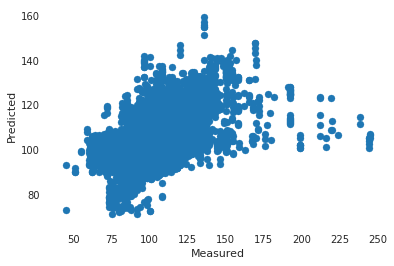

0.2916695982757076


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.16599e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.09987e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.21829e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.18774e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.12021e-21): result may not be accurate.
  overwrite_a=True).T
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAl

El R2 para Modelo Ridge es de: 0.2916648245067818


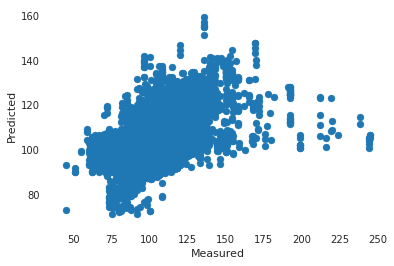

0.2916648245067818
El R2 para Modelo Lasso es de: 0.13719437695227787


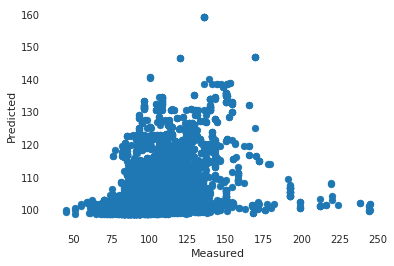

0.13719437695227787
El R2 para AdaBoostRegressor es de: 0.22876946908593132


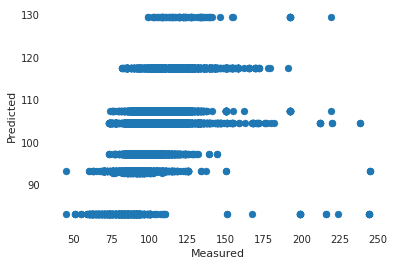

0.22876946908593132
El R2 para GradientBoostingRegressor es de: 0.7240080618992175


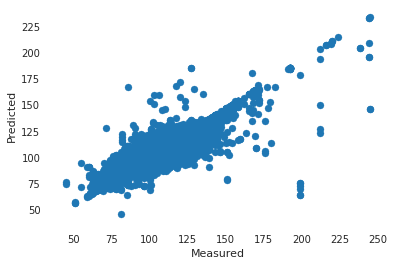

0.7240080618992175
El R2 para RandomForestRegressor es de: 0.7345362848730649


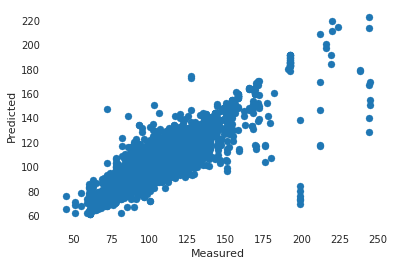

0.7345362848730649
El R2 para XGBRegressor es de: 0.8003908426639854


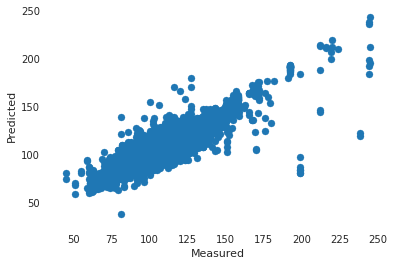

0.8003908426639854


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.1684028	total: 76.6ms	remaining: 306ms
1:	learn: 16.1258147	total: 80.2ms	remaining: 120ms
2:	learn: 16.0759728	total: 83.7ms	remaining: 55.8ms
3:	learn: 16.0459857	total: 87.1ms	remaining: 21.8ms
4:	learn: 15.9874523	total: 92.2ms	remaining: 0us
0:	learn: 16.3572519	total: 4.13ms	remaining: 16.5ms
1:	learn: 16.3154623	total: 7.58ms	remaining: 11.4ms
2:	learn: 16.2577388	total: 12ms	remaining: 8.01ms
3:	learn: 16.1636628	total: 15.9ms	remaining: 3.97ms
4:	learn: 16.1267220	total: 19.5ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 15.9838813	total: 3.95ms	remaining: 15.8ms
1:	learn: 15.9600162	total: 7.45ms	remaining: 11.2ms
2:	learn: 15.8545366	total: 11.2ms	remaining: 7.5ms
3:	learn: 15.7886346	total: 14.7ms	remaining: 3.68ms
4:	learn: 15.7054150	total: 18.1ms	remaining: 0us
0:	learn: 16.0634335	total: 3.85ms	remaining: 15.4ms
1:	learn: 16.0348465	total: 8.26ms	remaining: 12.4ms
2:	learn: 15.9687395	total: 11.6ms	remaining: 7.75ms
3:	learn: 15.9175304	total: 15.3ms	remaining: 3.82ms
4:	learn: 15.8855363	total: 18.7ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.1872745	total: 3.74ms	remaining: 14.9ms
1:	learn: 16.1420740	total: 8.02ms	remaining: 12ms
2:	learn: 16.0716839	total: 11.3ms	remaining: 7.54ms
3:	learn: 15.9898509	total: 14.9ms	remaining: 3.72ms
4:	learn: 15.8716959	total: 18.5ms	remaining: 0us
0:	learn: 16.0962212	total: 5.34ms	remaining: 21.4ms
1:	learn: 16.0166762	total: 10.1ms	remaining: 15.1ms
2:	learn: 15.8232163	total: 14.8ms	remaining: 9.88ms
3:	learn: 15.6809997	total: 19.9ms	remaining: 4.96ms
4:	learn: 15.5835793	total: 24.8ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.2340767	total: 4.96ms	remaining: 19.9ms
1:	learn: 16.1613345	total: 9.66ms	remaining: 14.5ms
2:	learn: 16.0728967	total: 14.4ms	remaining: 9.6ms
3:	learn: 15.9887707	total: 18.8ms	remaining: 4.71ms
4:	learn: 15.8099663	total: 23.8ms	remaining: 0us
0:	learn: 15.8467977	total: 5.26ms	remaining: 21ms
1:	learn: 15.7538274	total: 9.89ms	remaining: 14.8ms
2:	learn: 15.6351300	total: 15.2ms	remaining: 10.2ms
3:	learn: 15.5241965	total: 19.9ms	remaining: 4.97ms
4:	learn: 15.3749742	total: 25ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.0046868	total: 5.49ms	remaining: 22ms
1:	learn: 15.9242291	total: 10.7ms	remaining: 16.1ms
2:	learn: 15.7814929	total: 16.3ms	remaining: 10.9ms
3:	learn: 15.6831977	total: 22ms	remaining: 5.5ms
4:	learn: 15.6074535	total: 28.6ms	remaining: 0us
0:	learn: 16.1162542	total: 5.8ms	remaining: 23.2ms
1:	learn: 16.0315632	total: 11.5ms	remaining: 17.3ms
2:	learn: 15.8940816	total: 17.2ms	remaining: 11.4ms
3:	learn: 15.7941383	total: 22.9ms	remaining: 5.73ms
4:	learn: 15.6441576	total: 28.8ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.1684028	total: 5.72ms	remaining: 34.3ms
1:	learn: 16.1258147	total: 9.62ms	remaining: 24ms
2:	learn: 16.0759728	total: 13.5ms	remaining: 18ms
3:	learn: 16.0459857	total: 17.4ms	remaining: 13ms
4:	learn: 15.9874523	total: 22ms	remaining: 8.79ms
5:	learn: 15.9430624	total: 26.9ms	remaining: 4.48ms
6:	learn: 15.9188008	total: 33.5ms	remaining: 0us
0:	learn: 16.3572519	total: 4.95ms	remaining: 29.7ms
1:	learn: 16.3154623	total: 9.62ms	remaining: 24ms
2:	learn: 16.2577388	total: 13.8ms	remaining: 18.4ms
3:	learn: 16.1636628	total: 19ms	remaining: 14.2ms
4:	learn: 16.1267220	total: 23.2ms	remaining: 9.29ms
5:	learn: 16.0900013	total: 28.8ms	remaining: 4.81ms
6:	learn: 16.0483063	total: 33.4ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 15.9838813	total: 4.36ms	remaining: 26.2ms
1:	learn: 15.9600162	total: 8.73ms	remaining: 21.8ms
2:	learn: 15.8545366	total: 12.5ms	remaining: 16.7ms
3:	learn: 15.7886346	total: 16.6ms	remaining: 12.5ms
4:	learn: 15.7054150	total: 20.7ms	remaining: 8.28ms
5:	learn: 15.6788206	total: 24.7ms	remaining: 4.11ms
6:	learn: 15.6077452	total: 29.2ms	remaining: 0us
0:	learn: 16.0634335	total: 4.15ms	remaining: 24.9ms
1:	learn: 16.0348465	total: 8.12ms	remaining: 20.3ms
2:	learn: 15.9687395	total: 12ms	remaining: 16ms
3:	learn: 15.9175304	total: 17.4ms	remaining: 13ms
4:	learn: 15.8855363	total: 21.5ms	remaining: 8.61ms
5:	learn: 15.8532806	total: 25.6ms	remaining: 4.27ms
6:	learn: 15.7685392	total: 29.9ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.1872745	total: 6.14ms	remaining: 36.9ms
1:	learn: 16.1420740	total: 10.5ms	remaining: 26.2ms
2:	learn: 16.0716839	total: 15.3ms	remaining: 20.5ms
3:	learn: 15.9898509	total: 19.4ms	remaining: 14.6ms
4:	learn: 15.8716959	total: 23.6ms	remaining: 9.44ms
5:	learn: 15.7854570	total: 27.4ms	remaining: 4.56ms
6:	learn: 15.7325611	total: 31.5ms	remaining: 0us
0:	learn: 16.0962212	total: 5.73ms	remaining: 34.4ms
1:	learn: 16.0166762	total: 11.2ms	remaining: 28.1ms
2:	learn: 15.8232163	total: 17.2ms	remaining: 23ms
3:	learn: 15.6809997	total: 22.6ms	remaining: 17ms
4:	learn: 15.5835793	total: 30ms	remaining: 12ms
5:	learn: 15.4870075	total: 35.3ms	remaining: 5.89ms
6:	learn: 15.4091614	total: 41.4ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.2340767	total: 5.79ms	remaining: 34.7ms
1:	learn: 16.1613345	total: 12ms	remaining: 30.1ms
2:	learn: 16.0728967	total: 17.2ms	remaining: 22.9ms
3:	learn: 15.9887707	total: 24.8ms	remaining: 18.6ms
4:	learn: 15.8099663	total: 30.2ms	remaining: 12.1ms
5:	learn: 15.7043039	total: 35.5ms	remaining: 5.91ms
6:	learn: 15.6363262	total: 40.7ms	remaining: 0us
0:	learn: 15.8467977	total: 7.01ms	remaining: 42ms
1:	learn: 15.7538274	total: 12.5ms	remaining: 31.2ms
2:	learn: 15.6351300	total: 18ms	remaining: 24ms
3:	learn: 15.5241965	total: 23.7ms	remaining: 17.7ms
4:	learn: 15.3749742	total: 29.2ms	remaining: 11.7ms
5:	learn: 15.1704447	total: 34.2ms	remaining: 5.71ms
6:	learn: 15.0280283	total: 40ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.0046868	total: 4.82ms	remaining: 28.9ms
1:	learn: 15.9242291	total: 11.9ms	remaining: 29.7ms
2:	learn: 15.7814929	total: 17.4ms	remaining: 23.2ms
3:	learn: 15.6831977	total: 23.9ms	remaining: 17.9ms
4:	learn: 15.6074535	total: 29.4ms	remaining: 11.8ms
5:	learn: 15.4221981	total: 34.4ms	remaining: 5.74ms
6:	learn: 15.3110910	total: 39.4ms	remaining: 0us
0:	learn: 16.1162542	total: 5.43ms	remaining: 32.6ms
1:	learn: 16.0315632	total: 11ms	remaining: 27.5ms
2:	learn: 15.8940816	total: 16ms	remaining: 21.4ms
3:	learn: 15.7941383	total: 20.9ms	remaining: 15.7ms
4:	learn: 15.6441576	total: 25.8ms	remaining: 10.3ms
5:	learn: 15.3670175	total: 31.4ms	remaining: 5.23ms
6:	learn: 15.2676787	total: 36.4ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 16.0599927	total: 7.52ms	remaining: 45.1ms
1:	learn: 16.0165515	total: 13.6ms	remaining: 34ms
2:	learn: 15.8309150	total: 19.5ms	remaining: 26ms
3:	learn: 15.7407747	total: 25.9ms	remaining: 19.4ms
4:	learn: 15.6760413	total: 32ms	remaining: 12.8ms
5:	learn: 15.4081714	total: 41.7ms	remaining: 6.95ms
6:	learn: 15.3613302	total: 47.7ms	remaining: 0us
El R2 para CatBoostRegressor es de: 0.07530049582196285


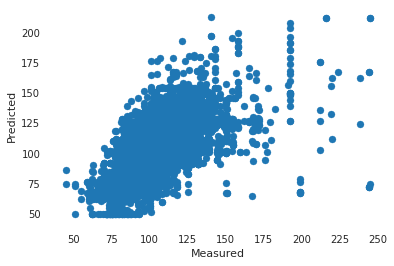

0.07530049582196285


,indices,nombres,hiperparametros,r2,tiempo,modelos
0,0,Regresiones Lineal,{},0.291670,1.0 segundos,"GridSearchCV(estimator=LinearRegression(), par..."
1,1,Modelo Ridge,{'alpha': 1},0.291665,1.0 segundos,"GridSearchCV(estimator=Ridge(), param_grid={'a..."
2,2,Modelo Lasso,{'alpha': 1},0.137194,0.0 segundos,"GridSearchCV(estimator=Lasso(), param_grid={'a..."
3,3,AdaBoostRegressor,"{'n_estimators': 2, 'random_state': 42}",0.228769,2.0 segundos,"GridSearchCV(estimator=AdaBoostRegressor(),\n ..."
4,4,GradientBoostingRegressor,"{'max_depth': 17, 'n_estimators': 25, 'random_...",0.724008,13.0 segundos,GridSearchCV(estimator=GradientBoostingRegress...
5,5,RandomForestRegressor,"{'max_depth': 30, 'n_estimators': 26, 'random_...",0.734536,13.0 segundos,GridSearchCV(estimator=RandomForestRegressor()...
6,6,XGBRegressor,"{'alpha': 0, 'iterations': 2, 'learning_rate':...",0.800391,44.0 segundos,GridSearchCV(estimator=XGBRegressor(base_score...
7,7,CatBoostRegressor,"{'iterations': 7, 'learning_rate': 2, 'max_dep...",0.075300,3.0 segundos,GridSearchCV(estimator=<catboost.core.CatBoost...


In [10]:
resultados = test_regresiones_sklearn(X,y)
resultados_r2 = pd.DataFrame({'indices':resultados['indices'],'nombres':resultados['modelos'],'hiperparametros':resultados['hiperparametros'],'r2':resultados['r2'],'tiempo':resultados['tiempo'],'modelos':resultados['modelos_train']})
resultados_r2

In [11]:
resultados_r2

,indices,nombres,hiperparametros,r2,tiempo,modelos
0,0,Regresiones Lineal,{},0.291670,1.0 segundos,"GridSearchCV(estimator=LinearRegression(), par..."
1,1,Modelo Ridge,{'alpha': 1},0.291665,1.0 segundos,"GridSearchCV(estimator=Ridge(), param_grid={'a..."
2,2,Modelo Lasso,{'alpha': 1},0.137194,0.0 segundos,"GridSearchCV(estimator=Lasso(), param_grid={'a..."
3,3,AdaBoostRegressor,"{'n_estimators': 2, 'random_state': 42}",0.228769,2.0 segundos,"GridSearchCV(estimator=AdaBoostRegressor(),\n ..."
4,4,GradientBoostingRegressor,"{'max_depth': 17, 'n_estimators': 25, 'random_...",0.724008,13.0 segundos,GridSearchCV(estimator=GradientBoostingRegress...
5,5,RandomForestRegressor,"{'max_depth': 30, 'n_estimators': 26, 'random_...",0.734536,13.0 segundos,GridSearchCV(estimator=RandomForestRegressor()...
6,6,XGBRegressor,"{'alpha': 0, 'iterations': 2, 'learning_rate':...",0.800391,44.0 segundos,GridSearchCV(estimator=XGBRegressor(base_score...
7,7,CatBoostRegressor,"{'iterations': 7, 'learning_rate': 2, 'max_dep...",0.075300,3.0 segundos,GridSearchCV(estimator=<catboost.core.CatBoost...


## ANALISIS DE RESULTADOS

In [17]:
from xgboost.sklearn import XGBRegressor,XGBClassifier
XGBRegressor = XGBRegressor(alpha=0,max_depth=14,iterations=2,learning_rate=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
modelo = XGBRegressor.fit(X_train,y_train)
predict = modelo.predict(X_test)
print('R2: '+str(r2_score(y_test,predict)))
import lime
import lime.lime_tabular
df_new = X_test

R2: 0.8003908426639854


In [18]:
with open('resultados_regresiones_duracion.pickle', 'wb') as handle:
    pickle.dump(XGBRegressor, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_array = df_new[(df_new.altas_ganancias==1)&(df_new.fecha_anio>2009)].sample(1)
df_array['Budget'] = df_array.Budget.astype(int)
XGBRegressor.predict(df_array)
import shap  
shap.initjs()

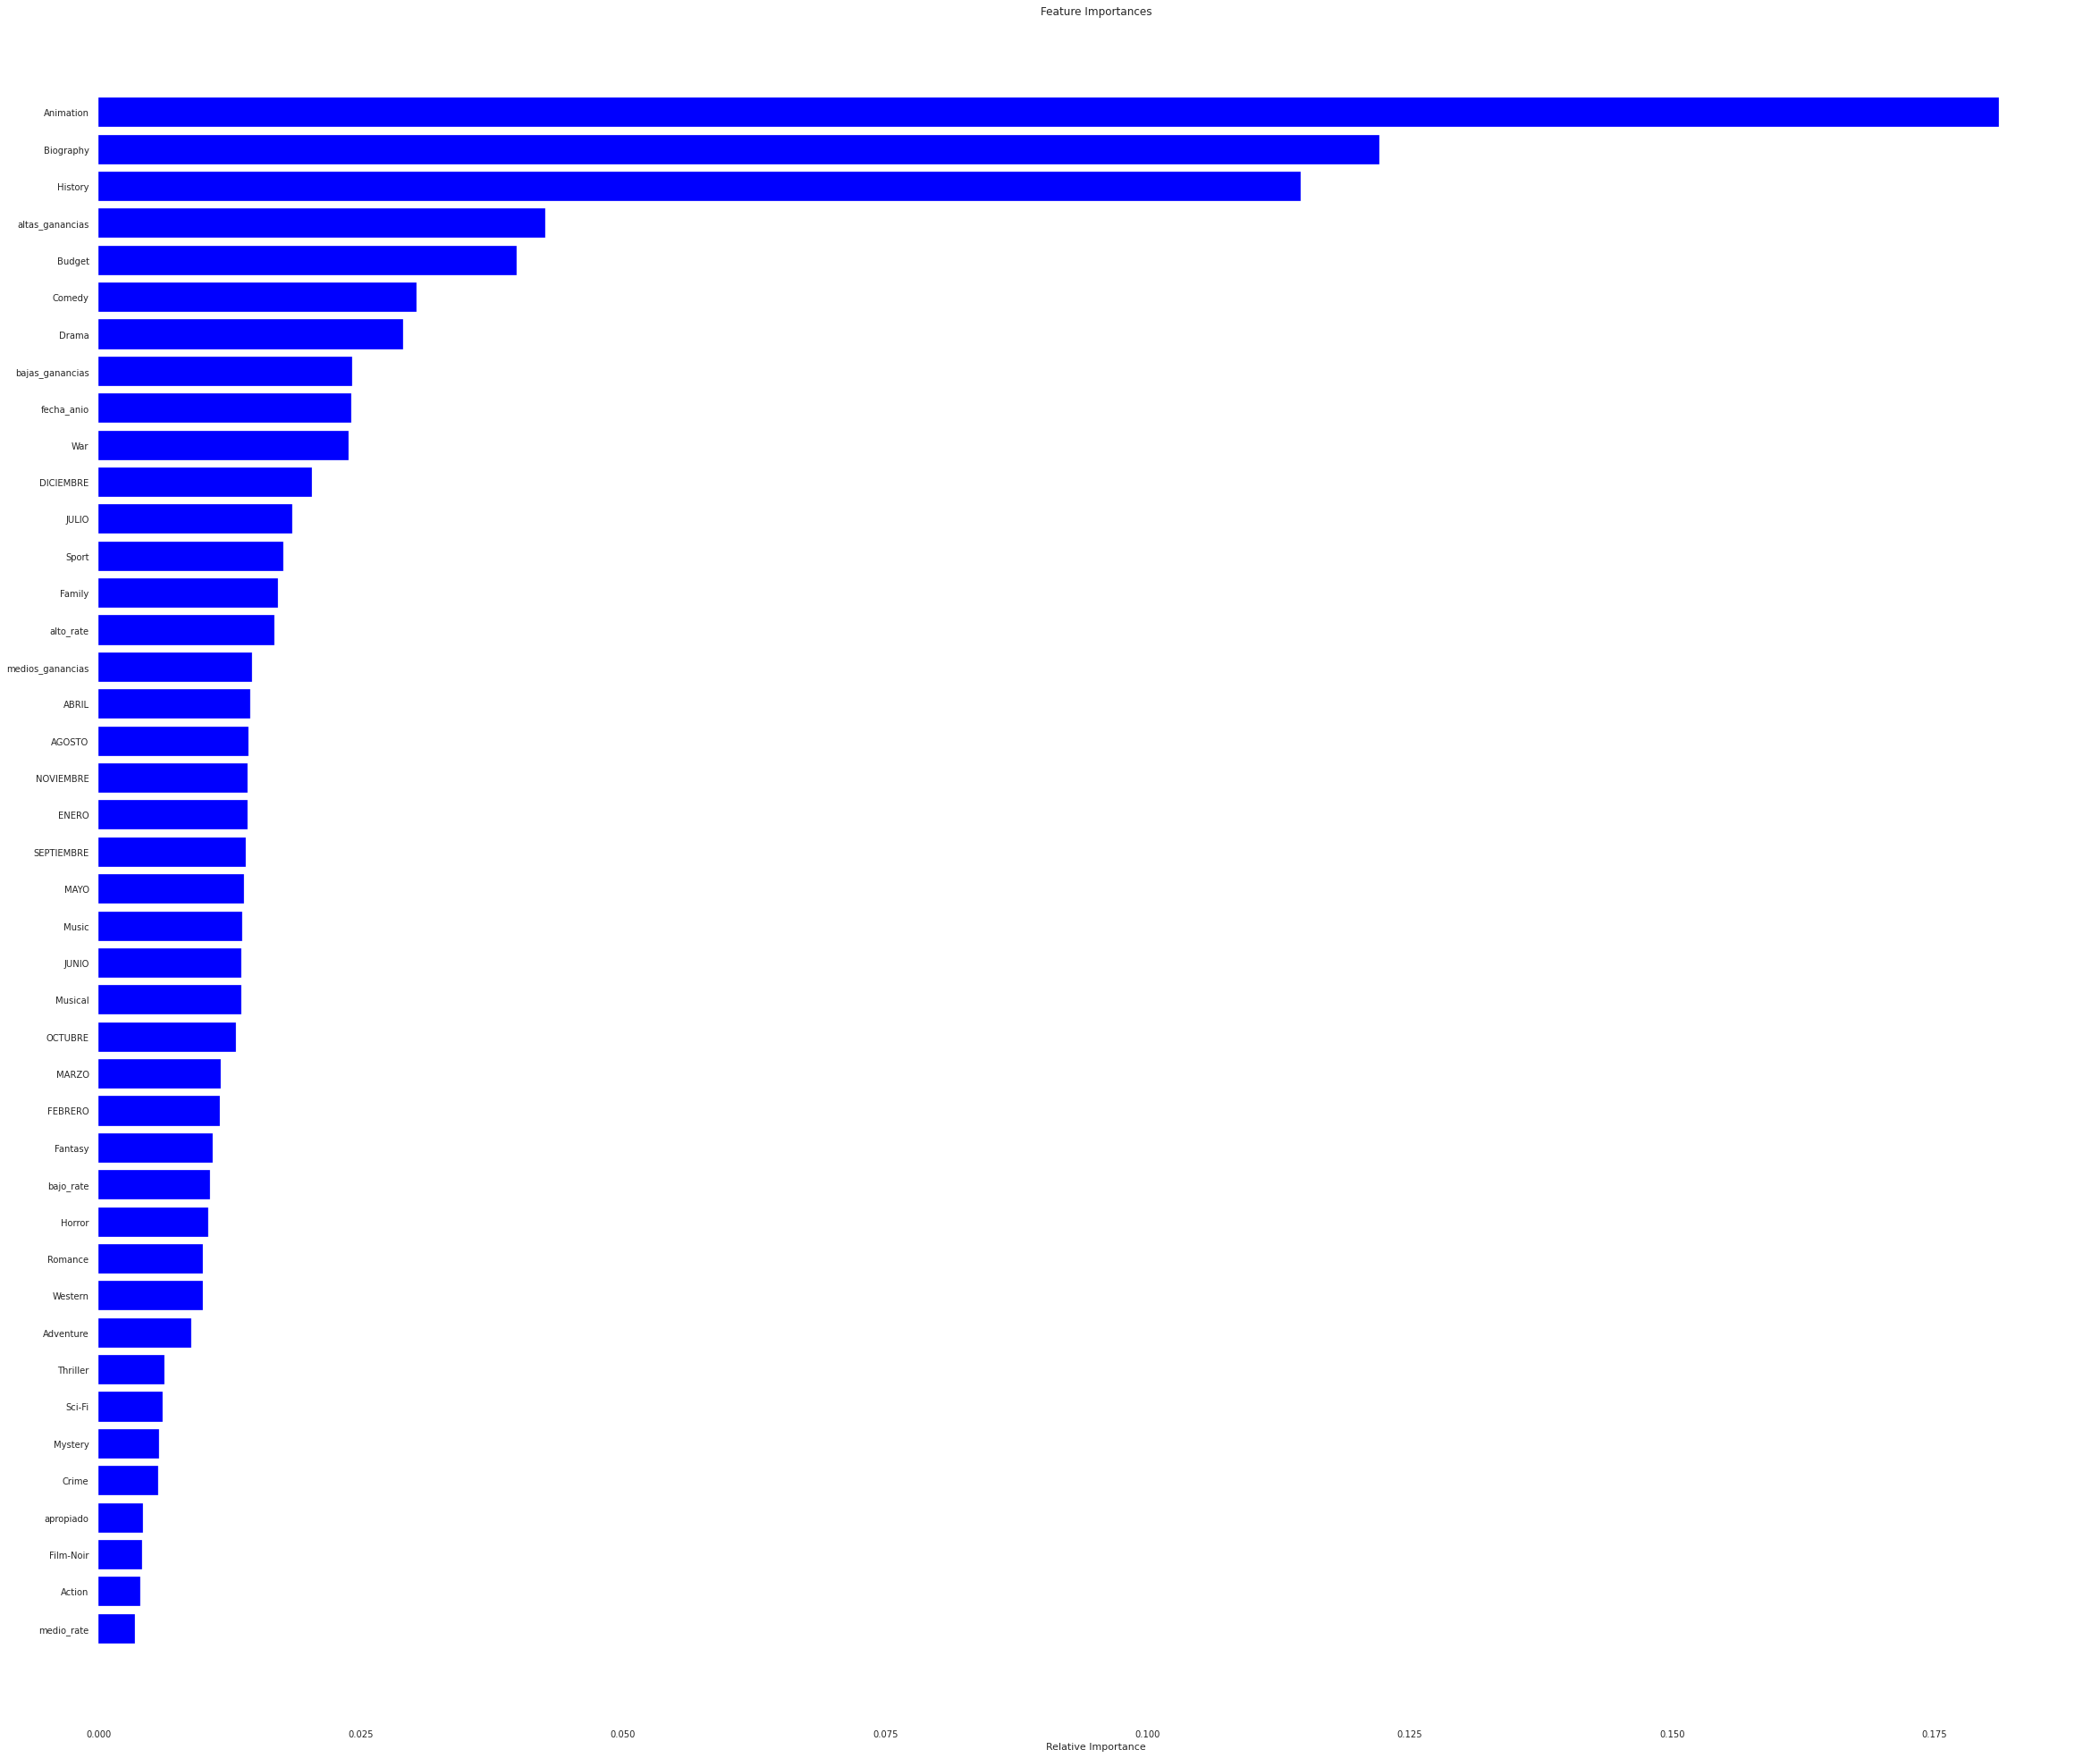

In [19]:
plt.figure(figsize=(40,35))
importances = XGBRegressor.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [20]:
explainer = shap.TreeExplainer(XGBRegressor)
shap_values = explainer.shap_values(df_array)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


## EJEMPLO LOCAL

In [21]:
features = X_train.columns
shap.force_plot(explainer.expected_value, shap_values, df_array,feature_names=features,out_names=['prediccion_minutos'])

In [17]:
explainer = shap.TreeExplainer(XGBRegressor)
shap_values = explainer.shap_values(X_test.sample(1000))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


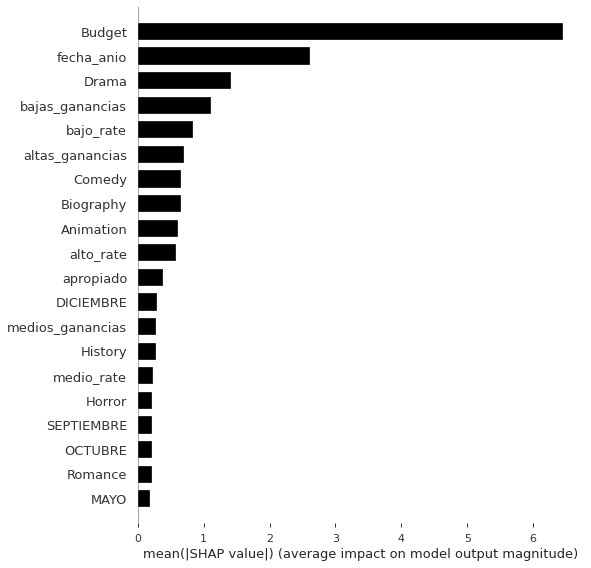

In [18]:
shap.summary_plot(shap_values, X_test.sample(1000), plot_type="bar",color='black')

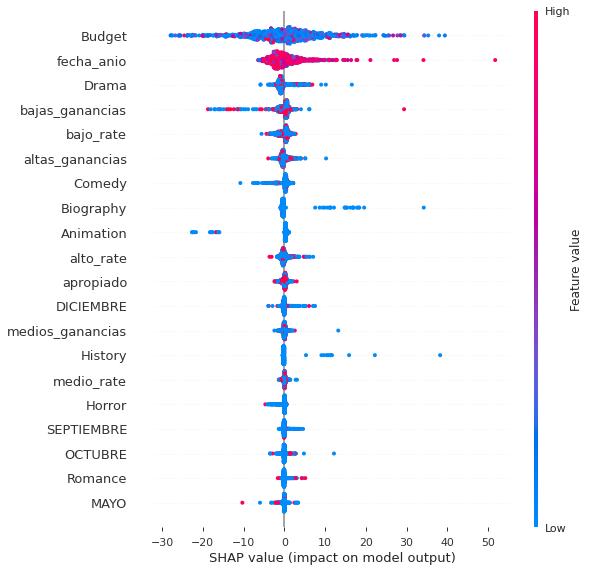

In [19]:
shap.summary_plot(shap_values, X_test.sample(1000))

In [20]:
shap.force_plot(explainer.expected_value, shap_values,X)

In [30]:
df_array = df_new[(df_new.altas_ganancias==1)&(df_new.Animation==1)&(df_new.fecha_anio==2015)].sample(1)

In [32]:
df_array

,Budget,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,ENERO,FEBRERO,MARZO,ABRIL,MAYO,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE,apropiado,fecha_anio,bajo_rate,medio_rate,alto_rate,bajas_ganancias,medios_ganancias,altas_ganancias
182235,80000000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2015,0,1,0,0,0,1


In [33]:
XGBRegressor.predict(df_array)[0]

89.38802